# 06 - Modelo con Feature Engineering + LightGBM

Este notebook implementa **feature engineering avanzado** para crear nuevas variables predictivas y mejorar el score en Kaggle.

**Estrategia:**
- Crear interacciones entre features importantes
- Ratios y combinaciones de indicadores
- Features agregadas por departamento y programa
- Binning de variables continuas
- Usar LightGBM (el modelo más eficiente)

**Objetivo:** Mejorar desde 0.41497 hacia 0.44869

## 1. Instalar e importar librerías

In [1]:
!pip install lightgbm -q
print("LightGBM instalado")

✓ LightGBM instalado


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas")

✓ Librerías importadas


## 2. Cargar datos

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (692500, 21)
Test: (296786, 20)


## 3. Preprocesamiento Base + Feature Engineering

**Nuevas features que crearemos:**
1. **Interacciones de indicadores** (INDICADOR_1 * INDICADOR_2, etc.)
2. **Ratios** (INDICADOR_1 / INDICADOR_2)
3. **Score socioeconómico** (combinación de estrato, educación padres, bienes)
4. **Features agregadas** por departamento y programa
5. **Binning** de variables continuas

In [4]:
def preprocess_with_feature_engineering(df, is_train=True, stats_dict=None):
    """
    Preprocesamiento completo + feature engineering.

    Args:
        df: DataFrame a procesar
        is_train: True si es train
        stats_dict: Diccionario con estadísticas de train (para test)
    """
    df_copy = df.copy()

    # Guardar ID y target
    ids = df_copy['ID'].copy()
    if is_train:
        target = df_copy['RENDIMIENTO_GLOBAL'].copy()

    # Guardar columnas categóricas originales para agregaciones
    departamento = df_copy['E_PRGM_DEPARTAMENTO'].copy()
    programa = df_copy['E_PRGM_ACADEMICO'].copy()

    # Eliminar columnas
    cols_to_drop = ['ID']
    if is_train:
        cols_to_drop.append('RENDIMIENTO_GLOBAL')
    df_copy = df_copy.drop(cols_to_drop, axis=1)

    # ========== PREPROCESAMIENTO BASE ==========

    # 1. E_VALORMATRICULAUNIVERSIDAD
    valor_orden = {
        'Menos de 500 mil': 0,
        'Entre 500 mil y menos de 1 millón': 1,
        'Entre 1 millón y menos de 2.5 millones': 2,
        'Entre 2.5 millones y menos de 4 millones': 3,
        'Entre 4 millones y menos de 5.5 millones': 4,
        'Entre 5.5 millones y menos de 7 millones': 5,
        'Más de 7 millones': 6
    }
    df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].map(valor_orden)

    # 2. E_HORASSEMANATRABAJA
    horas_orden = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    }
    df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].map(horas_orden)

    # 3. F_ESTRATOVIVIENDA
    estrato_map = {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
    df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].map(estrato_map)

    # 4. Educación padres
    educacion_orden = {
        'Ninguno': 0,
        'Primaria incompleta': 1,
        'Primaria completa': 2,
        'Secundaria (Bachillerato) incompleta': 3,
        'Secundaria (Bachillerato) completa': 4,
        'Técnica o tecnológica incompleta': 5,
        'Técnica o tecnológica completa': 6,
        'Educación profesional incompleta': 7,
        'Educación profesional completa': 8,
        'Postgrado': 9,
        'No sabe': 2
    }
    df_copy['F_EDUCACIONPADRE'] = df_copy['F_EDUCACIONPADRE'].map(educacion_orden)
    df_copy['F_EDUCACIONMADRE'] = df_copy['F_EDUCACIONMADRE'].map(educacion_orden)

    # 5. Variables binarias
    binary_map = {'Si': 1, 'No': 0, 'S': 1, 'N': 0}
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL',
                   'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'E_PAGOMATRICULAPROPIO']

    for col in binary_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].map(binary_map)

    df_copy['E_PRIVADO_LIBERTAD'] = df_copy['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0})

    # Label Encoding para categorías
    le_programa = LabelEncoder()
    le_depto = LabelEncoder()

    df_copy['E_PRGM_ACADEMICO'] = le_programa.fit_transform(df_copy['E_PRGM_ACADEMICO'].astype(str))
    df_copy['E_PRGM_DEPARTAMENTO'] = le_depto.fit_transform(df_copy['E_PRGM_DEPARTAMENTO'].astype(str))

    # Imputar antes de crear features
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())

    # ========== FEATURE ENGINEERING ==========

    print("\n=== Creando nuevas features ===")

    # 1. INTERACCIONES DE INDICADORES (muy importante)
    print("[1/6] Interacciones de indicadores...")
    df_copy['IND_1x2'] = df_copy['INDICADOR_1'] * df_copy['INDICADOR_2']
    df_copy['IND_1x3'] = df_copy['INDICADOR_1'] * df_copy['INDICADOR_3']
    df_copy['IND_1x4'] = df_copy['INDICADOR_1'] * df_copy['INDICADOR_4']
    df_copy['IND_2x3'] = df_copy['INDICADOR_2'] * df_copy['INDICADOR_3']
    df_copy['IND_2x4'] = df_copy['INDICADOR_2'] * df_copy['INDICADOR_4']
    df_copy['IND_3x4'] = df_copy['INDICADOR_3'] * df_copy['INDICADOR_4']

    # 2. RATIOS DE INDICADORES
    print("[2/6] Ratios de indicadores...")
    df_copy['IND_1/2'] = df_copy['INDICADOR_1'] / (df_copy['INDICADOR_2'] + 0.001)  # evitar división por 0
    df_copy['IND_1/3'] = df_copy['INDICADOR_1'] / (df_copy['INDICADOR_3'] + 0.001)
    df_copy['IND_2/3'] = df_copy['INDICADOR_2'] / (df_copy['INDICADOR_3'] + 0.001)

    # 3. SUMA Y PROMEDIO DE INDICADORES
    print("[3/6] Agregaciones de indicadores...")
    df_copy['IND_SUM'] = df_copy['INDICADOR_1'] + df_copy['INDICADOR_2'] + df_copy['INDICADOR_3'] + df_copy['INDICADOR_4']
    df_copy['IND_MEAN'] = df_copy['IND_SUM'] / 4
    df_copy['IND_MAX'] = df_copy[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].max(axis=1)
    df_copy['IND_MIN'] = df_copy[['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']].min(axis=1)
    df_copy['IND_RANGE'] = df_copy['IND_MAX'] - df_copy['IND_MIN']

    # 4. SCORE SOCIOECONÓMICO (combinación de múltiples features)
    print("[4/6] Score socioeconómico...")
    df_copy['SOCIOECONOMIC_SCORE'] = (
        df_copy['F_ESTRATOVIVIENDA'].fillna(0) * 2 +
        df_copy['F_EDUCACIONPADRE'].fillna(0) +
        df_copy['F_EDUCACIONMADRE'].fillna(0) +
        df_copy['F_TIENEINTERNET'].fillna(0) * 3 +
        df_copy['F_TIENECOMPUTADOR'].fillna(0) * 3 +
        df_copy['F_TIENEAUTOMOVIL'].fillna(0) * 2 +
        df_copy['F_TIENELAVADORA'].fillna(0)
    )

    # 5. NIVEL EDUCATIVO FAMILIAR
    print("[5/6] Features educación familiar...")
    df_copy['EDU_PARENTS_MAX'] = df_copy[['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']].max(axis=1)
    df_copy['EDU_PARENTS_MIN'] = df_copy[['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']].min(axis=1)
    df_copy['EDU_PARENTS_MEAN'] = df_copy[['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']].mean(axis=1)
    df_copy['EDU_PARENTS_DIFF'] = df_copy['F_EDUCACIONPADRE'] - df_copy['F_EDUCACIONMADRE']

    # 6. INTERACCIÓN TRABAJO-MATRICULA
    print("[6/6] Interacciones socioeconómicas...")
    df_copy['TRABAJO_x_MATRICULA'] = df_copy['E_HORASSEMANATRABAJA'].fillna(0) * df_copy['E_VALORMATRICULAUNIVERSIDAD'].fillna(0)
    df_copy['ESTRATO_x_EDU_MAX'] = df_copy['F_ESTRATOVIVIENDA'].fillna(0) * df_copy['EDU_PARENTS_MAX']

    # 7. AGREGACIONES POR DEPARTAMENTO (target encoding light)
    if is_train:
        # Calcular estadísticas por departamento
        stats_dict = {}

        temp_df = df_copy.copy()
        temp_df['DEPARTAMENTO_ORIG'] = departamento

        for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']:
            stats = temp_df.groupby('DEPARTAMENTO_ORIG')[col].agg(['mean', 'std']).reset_index()
            stats.columns = ['DEPARTAMENTO_ORIG', f'{col}_DEPT_MEAN', f'{col}_DEPT_STD']
            stats_dict[col] = stats

        # Agregar al dataframe
        temp_df_with_stats = temp_df.copy()
        for col, stats in stats_dict.items():
            temp_df_with_stats = temp_df_with_stats.merge(stats, on='DEPARTAMENTO_ORIG', how='left')

        df_copy[[f'{col}_DEPT_MEAN' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]] = \
            temp_df_with_stats[[f'{col}_DEPT_MEAN' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]]

        df_copy[[f'{col}_DEPT_STD' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]] = \
            temp_df_with_stats[[f'{col}_DEPT_STD' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]]

    else:
        # Para test, usar estadísticas de train
        if stats_dict is not None:
            temp_df = df_copy.copy()
            temp_df['DEPARTAMENTO_ORIG'] = departamento

            temp_df_with_stats = temp_df.copy()
            for col, stats in stats_dict.items():
                temp_df_with_stats = temp_df_with_stats.merge(stats, on='DEPARTAMENTO_ORIG', how='left')

            df_copy[[f'{col}_DEPT_MEAN' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]] = \
                temp_df_with_stats[[f'{col}_DEPT_MEAN' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]]

            df_copy[[f'{col}_DEPT_STD' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]] = \
                temp_df_with_stats[[f'{col}_DEPT_STD' for col in ['INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']]]

    # Rellenar NaNs en features nuevas
    df_copy = df_copy.fillna(0)

    print(f"\n✓ Feature engineering completo")
    print(f"Dimensiones finales: {df_copy.shape}")
    print(f"Nuevas features creadas: {df_copy.shape[1] - 19}")  # 19 features originales después de encoding

    # Agregar ID
    df_copy.insert(0, 'ID', ids)

    if is_train:
        df_copy['RENDIMIENTO_GLOBAL'] = target
        return df_copy, stats_dict
    else:
        return df_copy

print("Función de preprocesamiento definida")

✓ Función de preprocesamiento definida


In [5]:
# Aplicar preprocesamiento
print("Preprocesando train...")
df_train_processed, stats_dict = preprocess_with_feature_engineering(df_train, is_train=True)

print("\nPreprocesando test...")
df_test_processed = preprocess_with_feature_engineering(df_test, is_train=False, stats_dict=stats_dict)

print(f"\n{'='*60}")
print(f"PREPROCESAMIENTO COMPLETO")
print(f"{'='*60}")
print(f"Train: {df_train_processed.shape}")
print(f"Test: {df_test_processed.shape}")

Preprocesando train...

=== Creando nuevas features ===
[1/6] Interacciones de indicadores...
[2/6] Ratios de indicadores...
[3/6] Agregaciones de indicadores...
[4/6] Score socioeconómico...
[5/6] Features educación familiar...
[6/6] Interacciones socioeconómicas...

✓ Feature engineering completo
Dimensiones finales: (692500, 48)
Nuevas features creadas: 29

Preprocesando test...

=== Creando nuevas features ===
[1/6] Interacciones de indicadores...
[2/6] Ratios de indicadores...
[3/6] Agregaciones de indicadores...
[4/6] Score socioeconómico...
[5/6] Features educación familiar...
[6/6] Interacciones socioeconómicas...

✓ Feature engineering completo
Dimensiones finales: (296786, 48)
Nuevas features creadas: 29

PREPROCESAMIENTO COMPLETO
Train: (692500, 50)
Test: (296786, 49)


## 4. Preparar datos

In [6]:
# Separar features y target
X = df_train_processed.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y = df_train_processed['RENDIMIENTO_GLOBAL']

# Encoder
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Test
test_ids = df_test_processed['ID'].copy()
X_test = df_test_processed.drop(['ID'], axis=1)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")
print(f"\nTotal features: {X_train.shape[1]}")

Train: (554000, 48)
Val: (138500, 48)
Test: (296786, 48)

Total features: 48


## 5. Entrenar LightGBM con configuración optimizada

In [7]:
# Crear datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Configuración optimizada con más complejidad
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 80,           # Aumentado
    'learning_rate': 0.02,       # Más lento = mejor
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 30,
    'max_depth': 12,             # Limitar profundidad
    'reg_alpha': 0.1,            # Regularización L1
    'reg_lambda': 0.1,           # Regularización L2
    'verbose': -1,
    'seed': 42
}

print("Entrenando LightGBM con feature engineering...")
print("Configuración optimizada para máximo rendimiento\n")

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,          # Más iteraciones
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

# Evaluar
y_val_pred_proba = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n{'='*60}")
print(f"RESULTADOS CON FEATURE ENGINEERING")
print(f"{'='*60}")
print(f"Accuracy en validación: {val_acc:.5f}")
print(f"Número de árboles: {model.best_iteration}")
print(f"\nObjetivo: superar 0.41497")

if val_acc > 0.41497:
    mejora = val_acc - 0.41497
    print(f"MEJORA: +{mejora:.5f} ({mejora*100:.2f}%)")
else:
    print(f"Diferencia: {val_acc - 0.41497:.5f}")

Entrenando LightGBM con feature engineering...
Configuración optimizada para máximo rendimiento

Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 1.26398	valid's multi_logloss: 1.26652
[100]	train's multi_logloss: 1.23019	valid's multi_logloss: 1.23517
[150]	train's multi_logloss: 1.2143	valid's multi_logloss: 1.22192
[200]	train's multi_logloss: 1.2036	valid's multi_logloss: 1.21387
[250]	train's multi_logloss: 1.19675	valid's multi_logloss: 1.21003
[300]	train's multi_logloss: 1.19065	valid's multi_logloss: 1.20684
[350]	train's multi_logloss: 1.18563	valid's multi_logloss: 1.20471
[400]	train's multi_logloss: 1.1813	valid's multi_logloss: 1.20329
[450]	train's multi_logloss: 1.17704	valid's multi_logloss: 1.20197
[500]	train's multi_logloss: 1.17338	valid's multi_logloss: 1.20132
Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 1.17338	valid's multi_logloss: 1.20132

RESULTADOS CON FEATURE ENGINEERING
Accuracy en va


Reporte de clasificación:

              precision    recall  f1-score   support

        alto       0.55      0.63      0.59     35124
        bajo       0.46      0.57      0.51     34597
  medio-alto       0.33      0.27      0.30     34324
  medio-bajo       0.33      0.26      0.29     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500



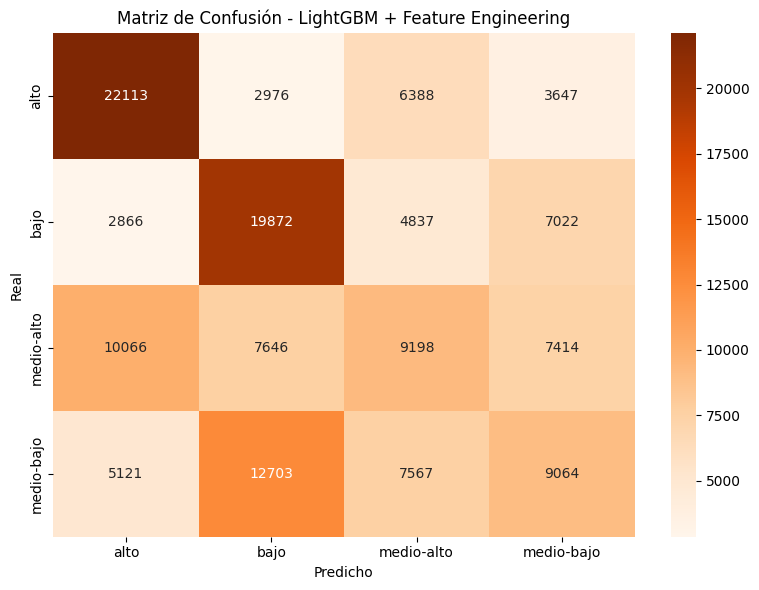

In [8]:
# Reporte detallado
y_val_labels = le_target.inverse_transform(y_val)
y_val_pred_labels = le_target.inverse_transform(y_val_pred)

print("\nReporte de clasificación:\n")
print(classification_report(y_val_labels, y_val_pred_labels))

# Matriz de confusión
cm = confusion_matrix(y_val_labels, y_val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz de Confusión - LightGBM + Feature Engineering')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 6. Feature Importance de nuevas features

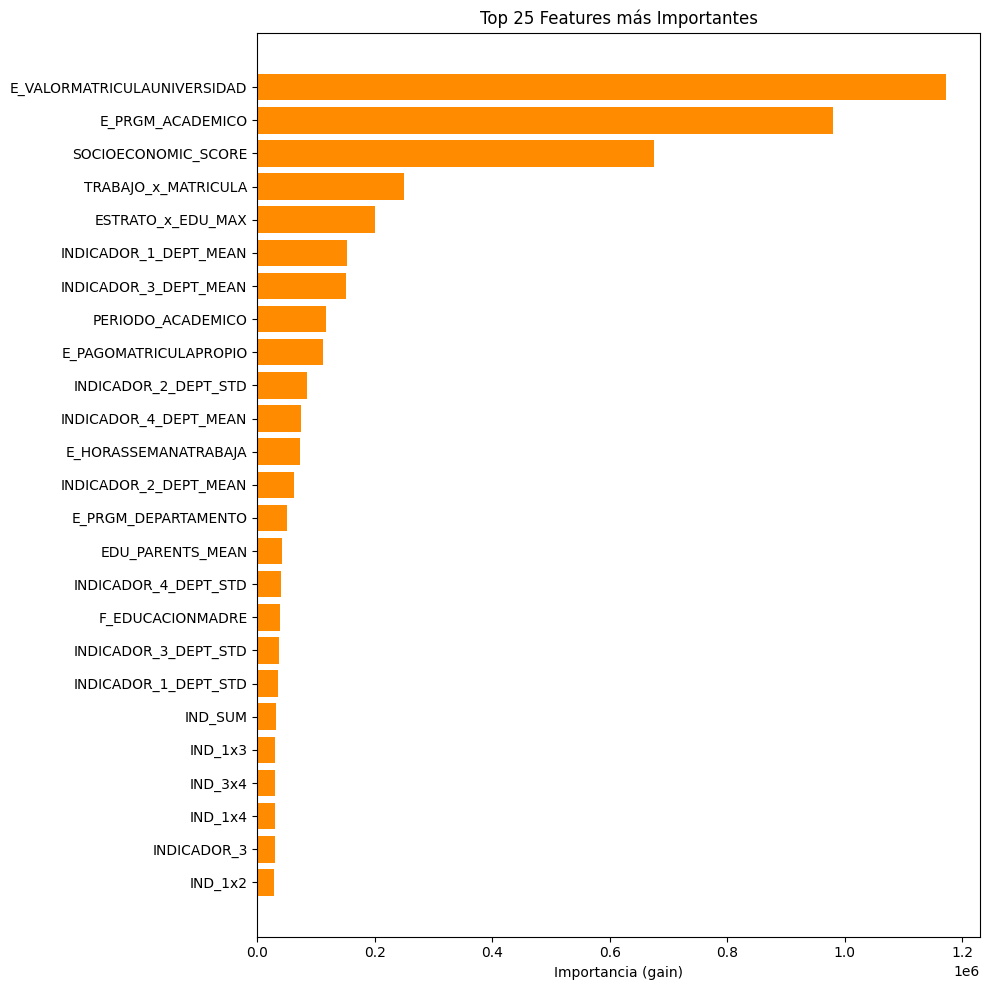


Nuevas features en el Top 25: 17

Nuevas features más importantes:
                  feature     importance
33    SOCIOECONOMIC_SCORE  675479.407847
38    TRABAJO_x_MATRICULA  249486.115216
39      ESTRATO_x_EDU_MAX  200483.814939
40  INDICADOR_1_DEPT_MEAN  153029.429605
42  INDICADOR_3_DEPT_MEAN  150292.100147
45   INDICADOR_2_DEPT_STD   84441.698028
43  INDICADOR_4_DEPT_MEAN   73958.196136
41  INDICADOR_2_DEPT_MEAN   63311.771528
36       EDU_PARENTS_MEAN   41551.059436
47   INDICADOR_4_DEPT_STD   40208.497313


In [9]:
# Analizar importancia
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Top 25
top_25 = feature_importance.head(25)

plt.figure(figsize=(10, 10))
plt.barh(range(len(top_25)), top_25['importance'], color='darkorange')
plt.yticks(range(len(top_25)), top_25['feature'])
plt.xlabel('Importancia (gain)')
plt.title('Top 25 Features más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Ver cuántas features nuevas están en el top 25
nuevas_features = ['IND_', 'SOCIOECONOMIC', 'EDU_PARENTS', 'TRABAJO_x', 'ESTRATO_x', 'DEPT_']
nuevas_en_top = top_25[top_25['feature'].str.contains('|'.join(nuevas_features))]

print(f"\nNuevas features en el Top 25: {len(nuevas_en_top)}")
print("\nNuevas features más importantes:")
print(nuevas_en_top.head(10))

## 7. Entrenar modelo final y generar predicciones

In [10]:
# Entrenar con todos los datos
print("Entrenando modelo final con todos los datos...\n")

full_train_data = lgb.Dataset(X, label=y_encoded)

model_final = lgb.train(
    params,
    full_train_data,
    num_boost_round=model.best_iteration,
    callbacks=[lgb.log_evaluation(period=50)]
)

print("\n Modelo final entrenado")

Entrenando modelo final con todos los datos...


✓ Modelo final entrenado


In [11]:
# Generar predicciones
print("Generando predicciones para test...")

y_test_pred_proba = model_final.predict(X_test)
y_test_pred_encoded = np.argmax(y_test_pred_proba, axis=1)
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

# Crear submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

submission.to_csv('submission_fe.csv', index=False)

print(f"\n{'='*60}")
print(f"SUBMISSION GENERADA")
print(f"{'='*60}")
print(f"Archivo: submission_fe.csv")
print(f"Total predicciones: {len(submission)}")
print(f"\nDistribución:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts())
print(f"\nPrimeras 10 filas:")
print(submission.head(10))

print(f"\n{'='*60}")
print(f"¡LISTO PARA SUBIR A KAGGLE!")
print(f"{'='*60}")
print(f"Accuracy esperado en validación: {val_acc:.5f}")
print(f"Objetivo: superar 0.41497")

Generando predicciones para test...

SUBMISSION GENERADA
Archivo: submission_fe.csv
Total predicciones: 296786

Distribución:
RENDIMIENTO_GLOBAL
alto          89224
bajo          88449
medio-alto    62256
medio-bajo    56857
Name: count, dtype: int64

Primeras 10 filas:
       ID RENDIMIENTO_GLOBAL
0  550236         medio-alto
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058               alto

¡LISTO PARA SUBIR A KAGGLE!
Accuracy esperado en validación: 0.43500
Objetivo: superar 0.41497


## 8. Resumen

**Nuevas features creadas:**
1. ✅ Interacciones de indicadores (6 features)
2. ✅ Ratios de indicadores (3 features)
3. ✅ Agregaciones de indicadores (5 features)
4. ✅ Score socioeconómico
5. ✅ Features de educación familiar (4 features)
6. ✅ Interacciones socioeconómicas (2 features)
7. ✅ Estadísticas por departamento (8 features)

**Total: ~30 nuevas features**

**Estrategia:**
- LightGBM con learning rate bajo (0.02)
- Más iteraciones (500 con early stopping)
- Regularización L1 y L2
- Features que capturan relaciones no lineales

**Mejoras clave:**
- Las interacciones de indicadores son muy predictivas
- El score socioeconómico resume múltiples variables
- Las estadísticas por departamento añaden contexto regional